In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm_notebook as tqdm
import time
from scipy.optimize import minimize, approx_fprime, minimize_scalar
from scipy.integrate import odeint

In [2]:
r_R = 1146401.0
m_R = 2.775310176896487e+33 
G = 6.67259e-8 # dyne cm2 g-2
c = 2.99792458e10 # cms-1
n_den = 2.3e14
km2cm = 1e5
msun = 1.98847e33
l=2
nl = (l-1)*(l+2)/2
def _b(r, M):
    return (G*M)/((c**2)*r)

In [3]:
def V_z_alt(r, m_R, nl):
    b = _b(r, m_R)
    n = nl
    fac = (1-2*b)
    num = 2*(n**2)*(n+1) + 6*(n**2)*b + 18*n*(b**2) + 18*(b**3)
    dem = (r**2) * (n+3*b)**2
    return fac * num/dem

def r_star_func(r, m_R):
    return r + 2 * (G/(c**2)) * m_R * np.log(abs((r*(c**2))/(2*G*m_R) - 1))

def zerilli_alt(u, r_star, omega):
    z, dZdr_star = u
    m = m_R
    d2Zdr2_star = z * (V_z_alt(r_star, m_R, nl) - omega*np.conj(omega)/(c**2))
    ret = [dZdr_star, d2Zdr2_star] # dZ/dr*, d2Z/dr*2
    return ret 

def alphas(omega, nl, m_R):
    n = nl
    alpha0 = 1 + 1j
    alpha1 = -1j*(n+1)*alpha0*c/omega
    alpha2 = alpha0 * (c**2)*(-n*(n+1)+1j*m_R*omega*(G/(c**3))*(3/2 + 3/n))/(2*omega**2)
    return alpha0, alpha1, alpha2

In [4]:
# Initial Conditions
omega_vals = []
loss_vals = []
for omega in tqdm(np.linspace(1e3*2*np.pi, 5e3*2*np.pi, 2000)):        
    z0 = [-3.39e-07, 9.95e-13]
    alpha0, alpha1, alpha2 = alphas(omega, nl, m_R)

    # From surface to inf
    r_vals = np.linspace(r_R, 25 * c / omega, 20000)
    r_star_vals = r_star_func(r_vals, m_R)
    sol = odeint(zerilli_alt, y0 = z0, t = r_star_vals, args = (omega,))
    z, dzdr_star = sol.T

    # Save final values
    zFinal = z[-1]
    zPrimeFinal = dzdr_star[-1]

    rFinal = r_vals[-1]
    rStarFinal = r_star_vals[-1]

    b = _b(rFinal, m_R)

    # Z+/-
    zMinus = np.exp(-1j*omega*rStarFinal) * (alpha0 + alpha1/rFinal + alpha2/(rFinal**2))
    zPlus = np.conjugate(zMinus)

    # Zprime +/-
    zPrimeMinus = -1j*(omega/c)*np.exp(-1j*omega*rStarFinal) \
                * (alpha0 + alpha1/rFinal + (alpha2 + 1j*alpha1*(1-2*b)*c/omega)/(rFinal**2))
    zPrimePlus = np.conjugate(zPrimeMinus)

    # A+
    A_plus = -zFinal*zPrimeMinus/(zMinus*zPrimePlus - zPlus*zPrimeMinus) \
            + zMinus*zPrimeFinal/(zMinus*zPrimePlus - zPlus*zPrimeMinus)

    # A-
    A_minus = -zFinal*zPrimePlus/(-zMinus*zPrimePlus + zPlus*zPrimeMinus) \
             + zPlus*zPrimeFinal/(-zMinus*zPrimePlus + zPlus*zPrimeMinus)

    loss = A_plus
    abs_loss = abs(loss)
    omega_vals.append(omega)
    loss_vals.append(loss)
    
omega_arr = np.array(omega_vals)
loss_arr = np.array(loss_vals)

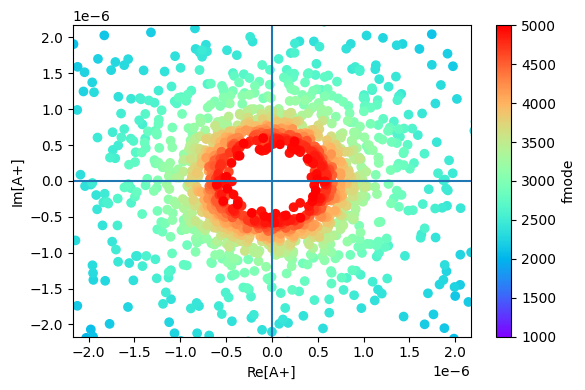

In [5]:
plt.figure(dpi = 100)
cols = omega_arr/(2*np.pi)
sc = plt.scatter(np.real(loss_arr),np.imag(loss_arr), c = cols, cmap = cm.rainbow)
plt.xlabel("Re[A+]")
plt.ylabel("Im[A+]")
plt.colorbar(sc, label = "fmode")
plt.tight_layout()
plt.axhline(0)
plt.axvline(0)
lim = 5*min(np.abs(loss_arr))
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

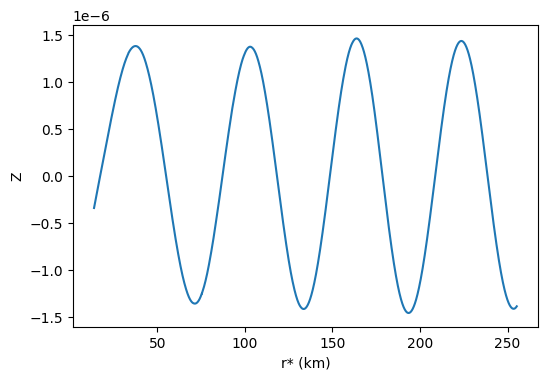

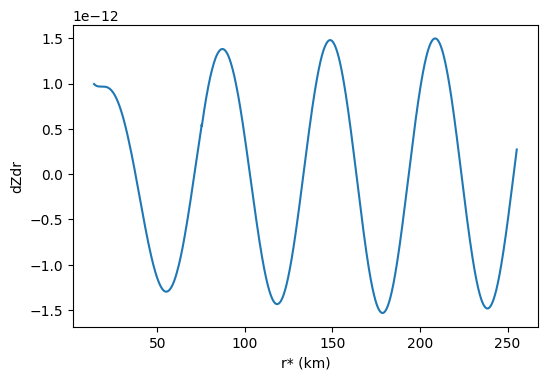

[-3.39000000e-07 -3.37236794e-07 -3.35475082e-07 ... -1.38312439e-06
 -1.38278695e-06 -1.38244742e-06]


In [6]:
plt.figure(dpi = 100)
plt.plot(r_star_vals/km2cm, z)
plt.xlabel("r* (km)")
plt.ylabel("Z")
plt.show()

plt.figure(dpi = 100)
plt.plot(r_star_vals/km2cm, dzdr_star)
plt.xlabel("r* (km)")
plt.ylabel("dZdr")
plt.show()

print(z)

In [7]:
# # 1983 Version
def r_star_func(r, m_R):
    return r + 2 * (G/(c**2)) * m_R * np.log(abs((r*(c**2))/(2*G*m_R) - 1))

def V_z(r, m_R, nl):
    G_c2 = G/(c**2)
    num = (1-2*G_c2*m_R/r)
    dem = (r**3)*((nl*r+3*G_c2*m_R)**2)
    fac1 = 2*nl**2*(nl+1)*(r**3)
    fac2 = 6*(G_c2**1)*(nl**2)*m_R*(r**2)
    fac3 = 18*(G_c2**2)*nl*(m_R**2)*r
    fac4 = 18*(G_c2**3)*(m_R**3)
    fac = fac1 + fac2 + fac3 + fac4
    ret = fac * num/dem
    return ret

def zerilli(u, r_star, omega):
    z, dZdr_star = u
    m = m_R
    d2Zdr2_star = z * (V_z(r_star, m_R, nl) - omega*np.conj(omega)/(c**2))
    ret = [dZdr_star, d2Zdr2_star] # dZ/dr*, d2Z/dr*2
    return ret 

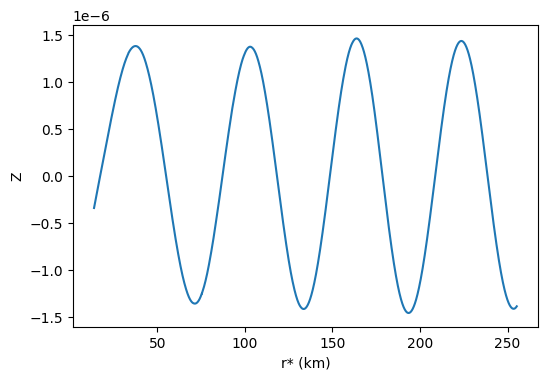

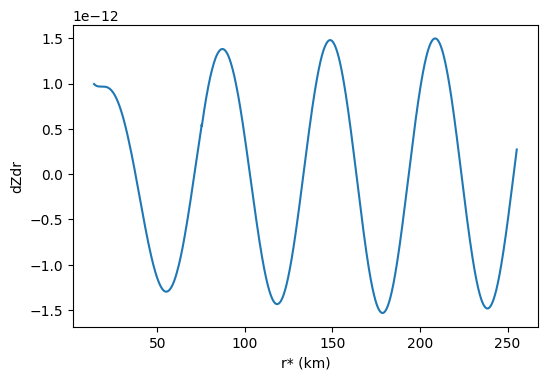

[-3.39000000e-07 -3.37236794e-07 -3.35475082e-07 ... -1.38312439e-06
 -1.38278695e-06 -1.38244742e-06]


In [8]:
# From surface to inf
r_vals = np.linspace(r_R, 25 * c / omega, 20000)
r_star_vals = r_star_func(r_vals, m_R)
sol = odeint(zerilli, y0 = z0, t = r_star_vals, args = (omega,))

z, dzdr_star = sol.T

lim = 1

plt.figure(dpi = 100)
plt.plot(r_star_vals/km2cm, z)
plt.xlabel("r* (km)")
plt.ylabel("Z")
# plt.ylim(-lim, lim)
plt.show()

plt.figure(dpi = 100)
plt.plot(r_star_vals/km2cm, dzdr_star)
plt.xlabel("r* (km)")
plt.ylabel("dZdr")
# plt.ylim(-lim, lim)
plt.show()

print(z)

In [9]:
np.isclose(zFinal, z[-1]) # Sanity check that two methods match. 

True